In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_multigroup_params, load_params
from multi_group_simulation import MultiGroupSimulation

In [2]:
base_params_free = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_free.yaml')[1]
base_params_selfiso = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_self_iso.yaml')[1]
base_params_post_movein = load_params('../src/simulations_v2/params/quarantine_analysis/oct12quarantine/ug_post_movein.yaml')[1]

In [201]:
pprint.pprint(base_params_free)

{'ID_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f65c3cb1bf8>,
 'SyID_mild_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f65b8600598>,
 'SyID_severe_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1d4d08>,
 'cases_isolated_per_contact': 0.5,
 'cases_quarantined_per_contact': 2.5,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'daily_outside_infection_p': 0,
 'days_between_tests': 1,
 'expected_contacts_per_day': 11.5,
 'exposed_infection_p': 0.017,
 'exposed_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1d4ea0>,
 'initial_E_count': 0,
 'initial_ID_count': 0,
 'initial_ID_prevalence': 0,
 'initial_SyID_mild_count': 0,
 'initial_SyID_severe_count': 0,
 'initial_pre_ID_count': 0,
 'max_time_ID': 8,
 'max_time_SyID_mild': 20,
 'max_time_SyID_severe': 20,
 'max_time_exposed': 7,
 'max_time_pre_ID': 4,
 'mild_severity_levels': 1,
 'mild_symptoms_daily

In [202]:
pprint.pprint(base_params_post_movein)

{'ID_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1e5510>,
 'SyID_mild_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1e5598>,
 'SyID_severe_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1e5620>,
 'cases_isolated_per_contact': 0.5,
 'cases_quarantined_per_contact': 2.5,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'daily_outside_infection_p': 2.2e-05,
 'days_between_tests': 1,
 'expected_contacts_per_day': 12.5,
 'exposed_infection_p': 0.02,
 'exposed_time_function': <function poisson_waiting_function.<locals>.<lambda> at 0x7f644a1e56a8>,
 'initial_E_count': 0,
 'initial_ID_count': 0,
 'initial_ID_prevalence': 0,
 'initial_SyID_mild_count': 0,
 'initial_SyID_severe_count': 0,
 'initial_pre_ID_count': 0,
 'max_time_ID': 8,
 'max_time_SyID_mild': 20,
 'max_time_SyID_severe': 20,
 'max_time_exposed': 7,
 'max_time_pre_ID': 4,
 'mild_severity_levels': 1,
 'mild_symptoms_

In [192]:
from analysis_helpers import binomial_exit_function
base_params_selfiso['population_size'] = 0
base_params_free['population_size'] = 1708
base_params_free['test_population_fraction'] = 0.0215
base_params_free['test_protocol_QFNR'] = 0.1
# data analysis shows 106 non-"arrival" positives during movein period
# 33 of these were found b/c of symptoms or surveillance
base_params_free['cases_isolated_per_contact'] = (106 - 33) / 33 
base_params_post_movein['test_population_fraction'] = 2/7
base_params_free['test_protocol_QFNR'] = 0.1
base_params_free['daily_outside_infection_p'] = 0
base_params_free['sample_QI_exit_function'] = binomial_exit_function(0)
base_params_post_movein['sample_QI_exit_function'] = binomial_exit_function(0)

init_pop_count = 1708
new_population_counts = [int(count) for count in """362
472
302
290
294
236
420
1801
1567
413
1017
255
706
351
773
332
342
186""".split('\n')]

movein_contact_matrix = np.matrix(
    [[base_params_free['expected_contacts_per_day'], 0],
    [0, base_params_selfiso['expected_contacts_per_day']]])

from dynamic_population_sim import DynamicPopulationSim

def init_movein_sim(transmissions_per_contact, isolations_per_trace=None):
    avg_init_cases = 4.29
    infxn_prob = avg_init_cases / (sum(new_population_counts) + init_pop_count)
    base_params = base_params_free.copy()
    init_exposed =  np.random.binomial(init_pop_count, infxn_prob)
    base_params['initial_E_count'] = init_exposed
    base_params['exposed_infection_p'] = transmissions_per_contact
    base_params_post_movein['exposed_infection_p'] = transmissions_per_contact
    if isolations_per_trace != None:
        base_params_free['cases_isolated_per_contact'] = isolations_per_trace
    free_group_population_dynamics = {}
    movein_time_horizon = 18 # 8/16 through 9/2
    new_case_exposed_rate = 1
    for t in range(movein_time_horizon):
        new_pop = new_population_counts[t]
        new_cases = np.random.binomial(new_pop, infxn_prob)
        new_exposed = np.random.binomial(new_cases, new_case_exposed_rate)
        free_group_population_dynamics[t] = {'S': new_pop - new_exposed, 'E': new_exposed, 'ID': new_cases- new_exposed}
    
    
    dynamic_pop_sim = DynamicPopulationSim(
        base_params,
        base_params_selfiso,
        base_params_post_movein,
        movein_contact_matrix,
        movein_time_horizon,
        free_group_population_dynamics,
        {}
    )
    return dynamic_pop_sim

In [78]:
np.random.binomial(1708, infxn_prob)

2

In [163]:
observed_data = """8/16/2020
0
8/25/2020
1
8/27/2020
2
8/28/2020
9
8/29/2020
10
8/30/2020
11
8/31/2020
16
9/1/2020
22
9/2/2020
33
9/3/2020
44
9/4/2020
57
9/5/2020
63
9/6/2020
68
9/7/2020
74
9/8/2020
77
9/9/2020
89
9/10/2020
94
9/11/2020
98
9/12/2020
100
9/16/2020
101
9/21/2020
102
9/22/2020
103
9/23/2020
104
9/28/2020
105
9/29/2020
106""".split('\n')

double_length = len(observed_data)
dates = []

for idx in range(int(double_length/2)):
    data[datetime.datetime.strptime(observed_data[2*idx], '%m/%d/%Y')] = int(observed_data[2*idx+1])

first_time = datetime.datetime(2020, 8, 16, 0, 0)
last_time = datetime.datetime(2020, 9, 29, 0, 0)
curr_time = first_time
one_day = datetime.timedelta(days=1)

curr_value = data[first_time]
actual_counts = []
dates = []

while curr_time <= last_time:
    actual_counts.append(curr_value)
    dates.append(curr_time)
    curr_time = curr_time + one_day
    if curr_time in data:
        curr_value = data[curr_time]
        

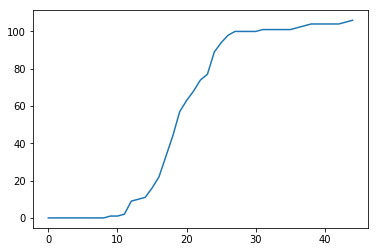

In [164]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(cum_counts)), actual_counts)

In [160]:
len(actual_counts)

45

In [206]:
import pandas as pd

def sample_movein_trajectory(transmission_p, isos_per_trace=None):
    dynamic_pop_sim = init_movein_sim(transmission_p, isos_per_trace)
    for _ in range(45):
        dynamic_pop_sim.step()
    movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
    post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

    
    post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
    df = pd.concat([movein_df, post_movein_df[1:]])

    return list(df['QI'])

def sample_trajectories(transmission_p, ntrajectories, isos_per_trace=None):
    trajectories = []
    for _ in range(ntrajectories):
        t = sample_movein_trajectory(transmission_p, isos_per_trace)
        trajectories.append(t)
    return trajectories


from math import sqrt

def score_trajectories(trajectories):
    errors = []
    for t in trajectories:
        error = 0
        for a, b in zip(t, actual_counts):
            error += (a-b)**2
        errors.append(sqrt(error / len(t)))
    return np.mean(errors)

In [221]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_trajectories(trajs, title):
    plt.figure(figsize=(10,6))
    label='Simulated Case Counts'
    for t in trajs:
        plt.plot(range(len(t)), t, color='blue', alpha=0.5, label=label)
        label=None
    plt.plot(range(len(actual_counts)), actual_counts, color='red', linewidth=3, 
             alpha=0.7, label='Observed Case Counts')
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

score = 56.92040061248246


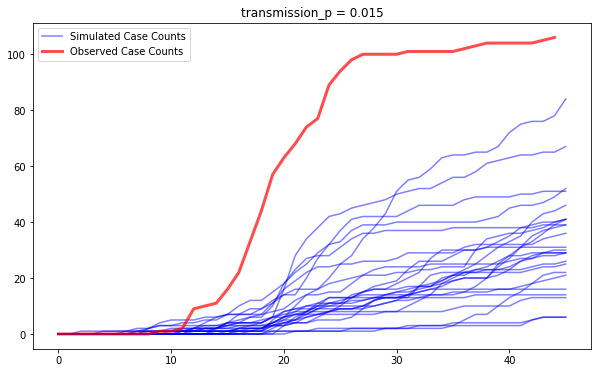

score = 56.69203031027685


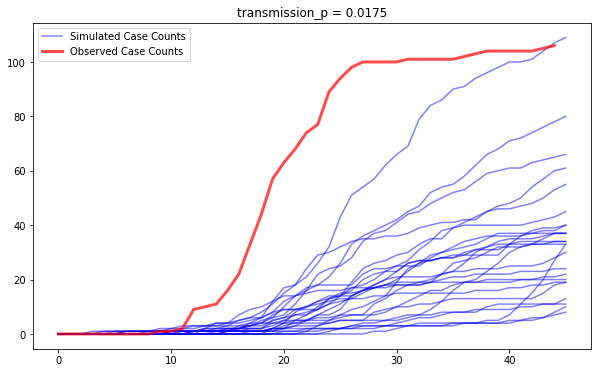

score = 51.77033474387203


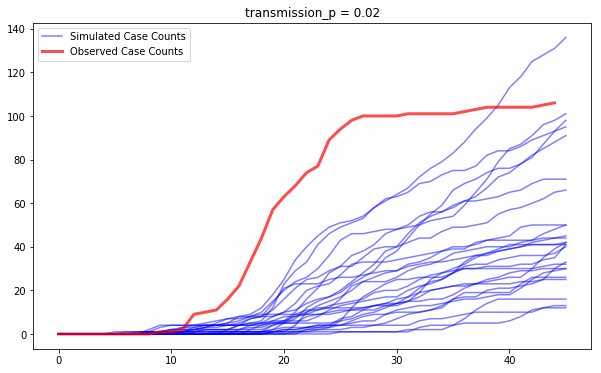

score = 42.47582201366435


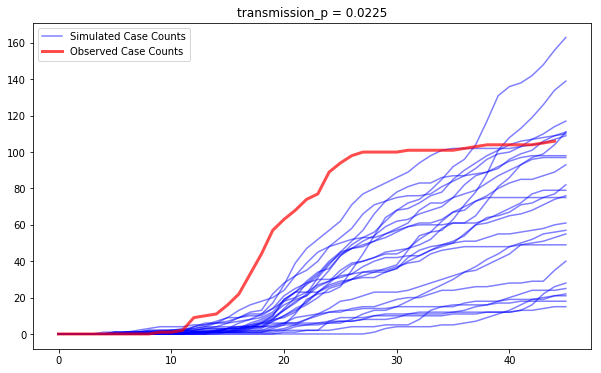

score = 42.186951182278364


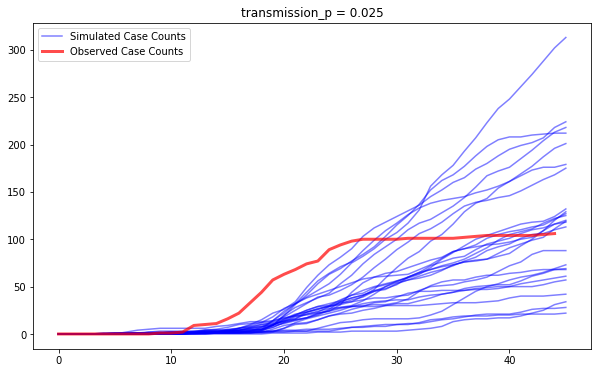

score = 49.44642315009659


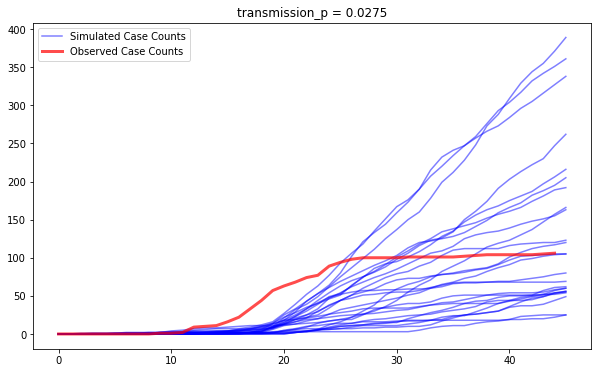

score = 73.58726358657502


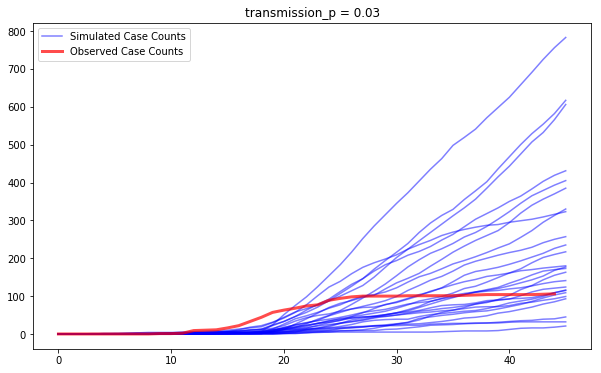

In [222]:
transmission_ps = [0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03]
results = {}
scores = {}
ntrajectories = 25

for transmission_p in transmission_ps:
    trajs = sample_trajectories(transmission_p, ntrajectories)
    results[transmission_p] = trajs
    score = score_trajectories(trajs)
    print("score = {}".format(score))
    scores[transmission_p] = score
    plot_trajectories(trajs, "transmission_p = {}".format(transmission_p))

Text(0,0.5,'Average RMSE')

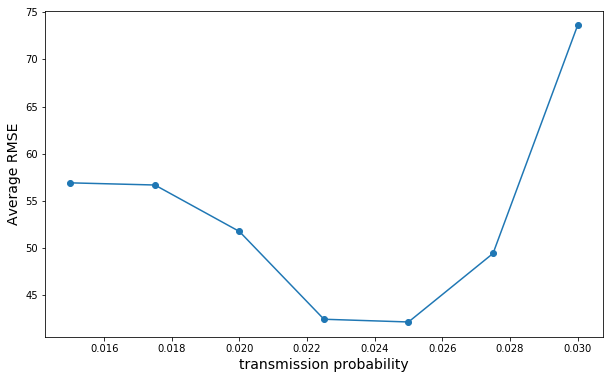

In [227]:
score_list = [scores[tr] for tr in transmission_ps]
plt.figure(figsize=(10,6))
plt.plot(transmission_ps, score_list, marker='o')
plt.xlabel("transmission probability", fontsize=14)
plt.ylabel("Average RMSE", fontsize=14)

score = 63.77873021410054


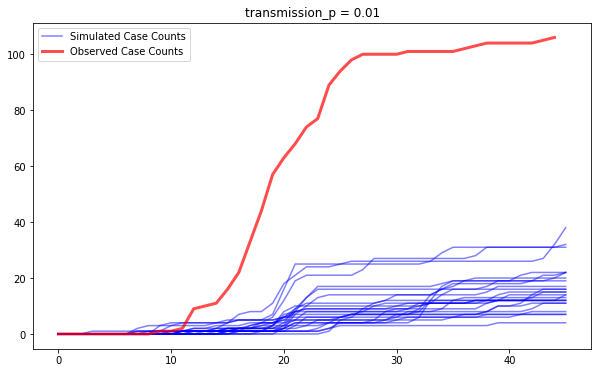

score = 61.76843082406452


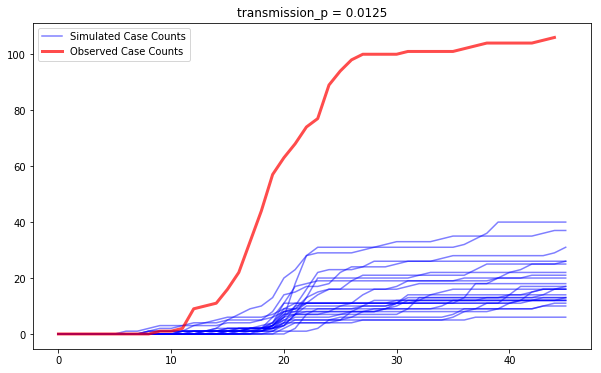

score = 60.76038045056251


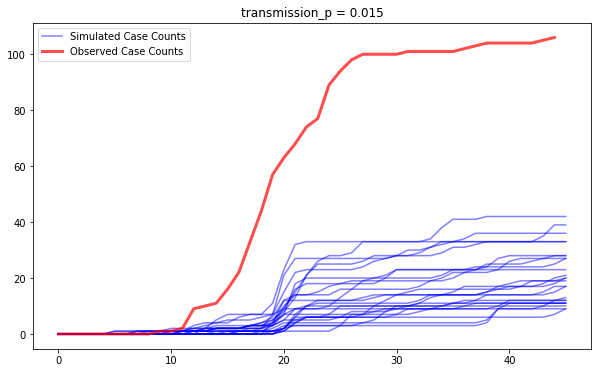

score = 58.02347662368369


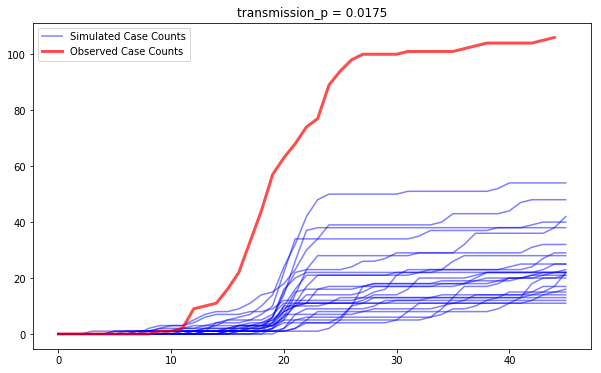

score = 52.09086959563299


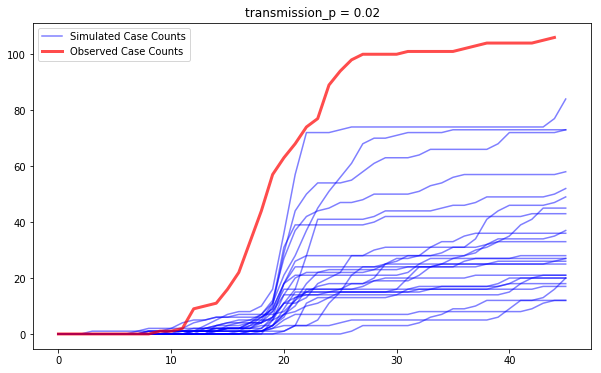

score = 52.460304485763885


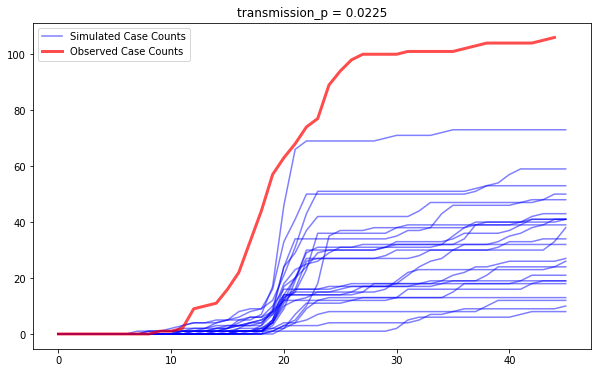

score = 46.186689580046284


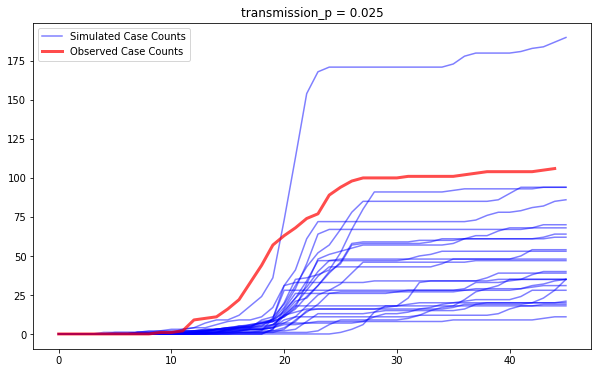

score = 47.64134442281201


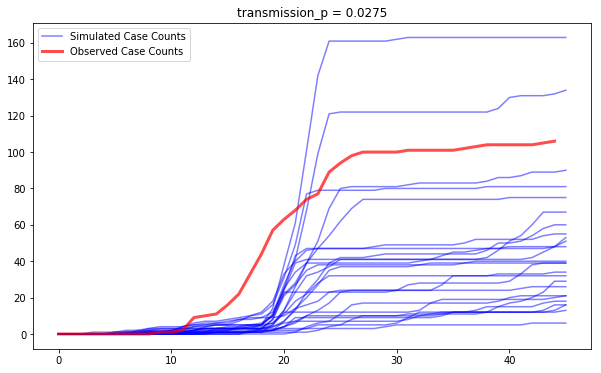

score = 43.3871267109216


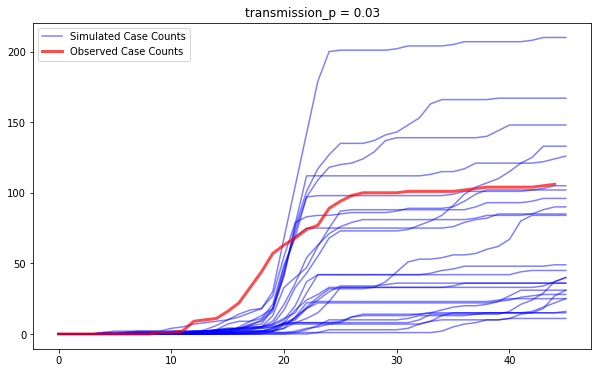

score = 39.049822872258694


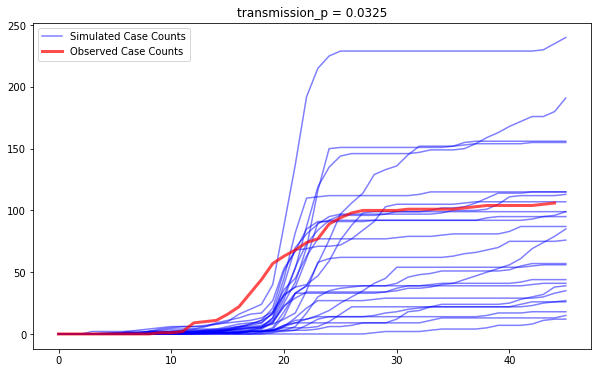

score = 42.60892332291641


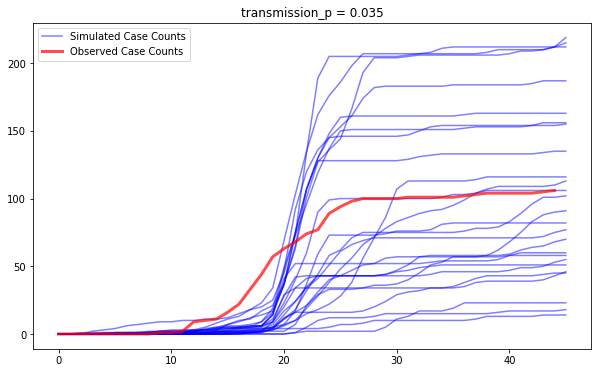

score = 61.84745826643727


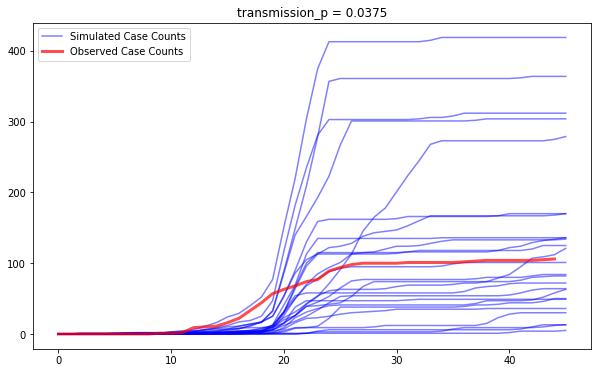

score = 71.73590805549287


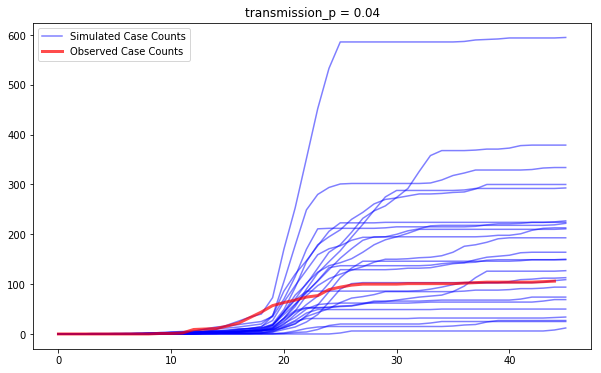

Text(0,0.5,'Average RMSE')

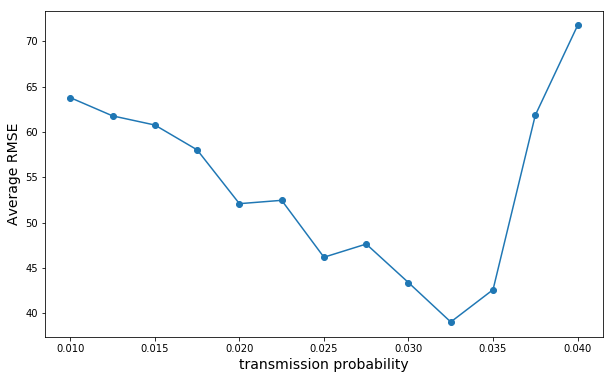

In [229]:
base_params_post_movein['cases_isolated_per_contact']=(106-33)/33
transmission_ps = [0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325, 0.035, 0.0375, 0.04]
results = {}
scores = {}
ntrajectories = 25

for transmission_p in transmission_ps:
    trajs = sample_trajectories(transmission_p, ntrajectories)
    results[transmission_p] = trajs
    score = score_trajectories(trajs)
    print("score = {}".format(score))
    scores[transmission_p] = score
    plot_trajectories(trajs, "transmission_p = {}".format(transmission_p))
    
score_list = [scores[tr] for tr in transmission_ps]
plt.figure(figsize=(10,6))
plt.plot(transmission_ps, score_list, marker='o')
plt.xlabel("transmission probability", fontsize=14)
plt.ylabel("Average RMSE", fontsize=14)

In [219]:
trajs = sample_trajectories(0.02, 10, isos_per_trace=None)


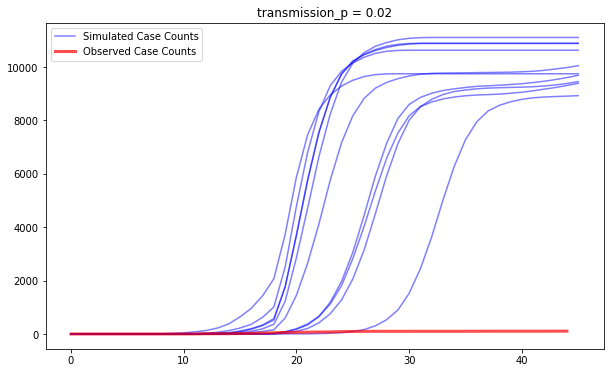

In [218]:
plot_trajectories(trajs, "transmission_p = 0.02")

In [180]:
score_trajectories(trajs)

57.511464566369526

In [190]:
trajs = sample_trajectories(0.3, 10)


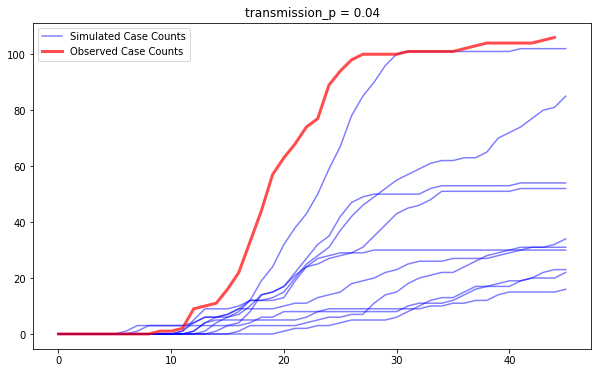

In [191]:
plot_trajectories(trajs, "transmission_p = 0.04")

In [170]:
df = sample_movein_trajectory(0.02)

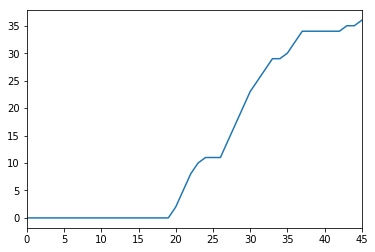

In [171]:
df.plot()

In [173]:
list(df)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 5,
 8,
 10,
 11,
 11,
 11,
 14,
 17,
 20,
 23,
 25,
 27,
 29,
 29,
 30,
 32,
 34,
 34,
 34,
 34,
 34,
 34,
 35,
 35,
 36]

In [165]:
dynamic_pop_sim = init_movein_sim(0.02)

In [166]:
for _ in range(45):
    dynamic_pop_sim.step()

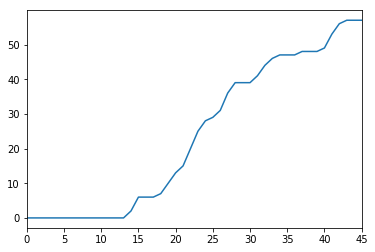

In [168]:
%matplotlib inline
movein_df = dynamic_pop_sim.movein_sim.sims[0].sim_df
post_movein_df = dynamic_pop_sim.post_movein_sim.sim_df

import pandas as pd
post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)
df = pd.concat([movein_df, post_movein_df[1:]])

df['QI'].plot()

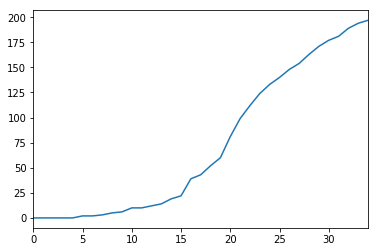

In [123]:
df[['cumulative_severe', 'cumulative_mild']].sum(axis=1).plot()

In [91]:
movein_df[['cumulative_severe', 'cumulative_mild']].sum(axis=1)

0      0.0
1      0.0
2      0.0
3      1.0
4      1.0
5      1.0
6      1.0
7      2.0
8      2.0
9      2.0
10     4.0
11     4.0
12     4.0
13     8.0
14    10.0
15    12.0
16    13.0
17    17.0
18    20.0
dtype: float64

In [92]:
post_movein_df[1:][['cumulative_severe', 'cumulative_mild']].sum(axis=1)

1     23.0
2     32.0
3     36.0
4     41.0
5     48.0
6     52.0
7     58.0
8     64.0
9     69.0
10    75.0
11    78.0
12    81.0
dtype: float64

In [93]:
post_movein_df.index = range(movein_df.shape[0]-1, post_movein_df.shape[0] + movein_df.shape[0] -1)

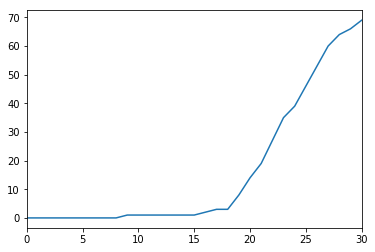

In [94]:
df = pd.concat([movein_df, post_movein_df[1:]])
df['QI'].plot()

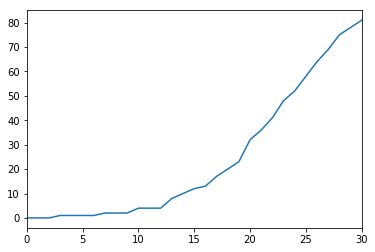

In [95]:
df[['cumulative_severe', 'cumulative_mild']].sum(axis=1).plot()

In [51]:
df

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,SyID_severe_13,SyID_severe_14,SyID_severe_15,SyID_severe_16,SyID_severe_17,SyID_severe_18,SyID_severe_19,cumulative_mild,cumulative_severe,cumulative_outside_infections
0,1707,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2069,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2540,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2841,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,3422,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
6,3657,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,2,0,0
7,4077,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,1,0
8,5876,2,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,2,0
9,7442,2,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,5,2,1


In [8]:
new_population_counts[0]

TypeError: 'map' object is not subscriptable

In [125]:
import datetime
datetime.datetime.strptime('8/16/2020', '%m/%d/%Y')

datetime.datetime(2020, 8, 16, 0, 0)

In [138]:
observed_data = """8/16/2020
0
8/25/2020
1
8/27/2020
2
8/28/2020
9
8/29/2020
10
8/30/2020
11
8/31/2020
16
9/1/2020
22
9/2/2020
33
9/3/2020
44
9/4/2020
57
9/5/2020
63
9/6/2020
68
9/7/2020
74
9/8/2020
77
9/9/2020
89
9/10/2020
94
9/11/2020
98
9/12/2020
100
9/16/2020
101
9/21/2020
102
9/22/2020
103
9/23/2020
104
9/28/2020
105
9/29/2020
106""".split('\n')

double_length = len(observed_data)
dates = []

for idx in range(int(double_length/2)):
    data[datetime.datetime.strptime(observed_data[2*idx], '%m/%d/%Y')] = int(observed_data[2*idx+1])

first_time = datetime.datetime(2020, 8, 16, 0, 0)
last_time = datetime.datetime(2020, 9, 29, 0, 0)
curr_time = first_time
one_day = datetime.timedelta(days=1)

curr_value = data[first_time]
actual_counts = []
dates = []

while curr_time <= last_time:
    actual_counts.append(curr_value)
    dates.append(curr_time)
    curr_time = curr_time + one_day
    if curr_time in data:
        curr_value = data[curr_time]
        

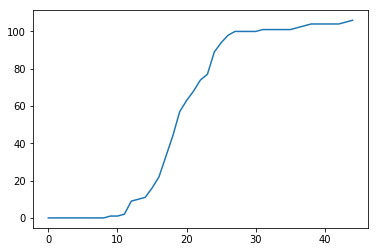

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(cum_counts)), cum_counts)

In [140]:
dates

[datetime.datetime(2020, 8, 16, 0, 0),
 datetime.datetime(2020, 8, 17, 0, 0),
 datetime.datetime(2020, 8, 18, 0, 0),
 datetime.datetime(2020, 8, 19, 0, 0),
 datetime.datetime(2020, 8, 20, 0, 0),
 datetime.datetime(2020, 8, 21, 0, 0),
 datetime.datetime(2020, 8, 22, 0, 0),
 datetime.datetime(2020, 8, 23, 0, 0),
 datetime.datetime(2020, 8, 24, 0, 0),
 datetime.datetime(2020, 8, 25, 0, 0),
 datetime.datetime(2020, 8, 26, 0, 0),
 datetime.datetime(2020, 8, 27, 0, 0),
 datetime.datetime(2020, 8, 28, 0, 0),
 datetime.datetime(2020, 8, 29, 0, 0),
 datetime.datetime(2020, 8, 30, 0, 0),
 datetime.datetime(2020, 8, 31, 0, 0),
 datetime.datetime(2020, 9, 1, 0, 0),
 datetime.datetime(2020, 9, 2, 0, 0),
 datetime.datetime(2020, 9, 3, 0, 0),
 datetime.datetime(2020, 9, 4, 0, 0),
 datetime.datetime(2020, 9, 5, 0, 0),
 datetime.datetime(2020, 9, 6, 0, 0),
 datetime.datetime(2020, 9, 7, 0, 0),
 datetime.datetime(2020, 9, 8, 0, 0),
 datetime.datetime(2020, 9, 9, 0, 0),
 datetime.datetime(2020, 9, 10, 0,

In [129]:
data.keys()

dict_keys([datetime.datetime(2020, 8, 16, 0, 0), datetime.datetime(2020, 8, 25, 0, 0), datetime.datetime(2020, 8, 27, 0, 0), datetime.datetime(2020, 8, 28, 0, 0), datetime.datetime(2020, 8, 29, 0, 0), datetime.datetime(2020, 8, 30, 0, 0), datetime.datetime(2020, 8, 31, 0, 0), datetime.datetime(2020, 9, 1, 0, 0), datetime.datetime(2020, 9, 2, 0, 0), datetime.datetime(2020, 9, 3, 0, 0), datetime.datetime(2020, 9, 4, 0, 0), datetime.datetime(2020, 9, 5, 0, 0), datetime.datetime(2020, 9, 6, 0, 0), datetime.datetime(2020, 9, 7, 0, 0), datetime.datetime(2020, 9, 8, 0, 0), datetime.datetime(2020, 9, 9, 0, 0), datetime.datetime(2020, 9, 10, 0, 0), datetime.datetime(2020, 9, 11, 0, 0), datetime.datetime(2020, 9, 12, 0, 0), datetime.datetime(2020, 9, 16, 0, 0), datetime.datetime(2020, 9, 21, 0, 0), datetime.datetime(2020, 9, 22, 0, 0), datetime.datetime(2020, 9, 23, 0, 0), datetime.datetime(2020, 9, 28, 0, 0), datetime.datetime(2020, 9, 29, 0, 0)])

In [132]:
first = datetime.datetime(2020, 8, 16, 0, 0)
first + datetime.timedelta(days=1)

datetime.datetime(2020, 8, 17, 0, 0)